# Portfolio Risk Analysis and Tearsheet

This notebook performs risk and performance analysis for a portfolio consisting of:
- Amazon (AMZN): 25%
- FedEx (FDX): 30%
- Nvidia (NVDA): 45%

Period: July 24, 2023 to July 24, 2024

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import warnings
from fpdf import FPDF

# Set plot styling
plt.style.use('fivethirtyeight')
sns.set_context("talk")
warnings.filterwarnings('ignore')

# Format percentage display
def percentage_format(x, pos):
    return f'{100 * x:.1f}%'

## 1. Data Collection and Preparation

In [2]:
# Define portfolio parameters
tickers = ['AMZN', 'FDX', 'NVDA']
weights = np.array([0.25, 0.30, 0.45])
benchmark_ticker = '^GSPC'  # S&P 500

# Define time period
start_date = '2023-07-24'
end_date = '2024-07-24'

# Robust function to download stock data
def download_stock_data(tickers, start_date, end_date):
    """Download stock data with proper error handling"""
    print(f"Downloading data for {tickers} from {start_date} to {end_date}")
    
    # Download data
    raw_data = yf.download(tickers, start=start_date, end=end_date)
    print(f"Data shape: {raw_data.shape}")
    
    # Handle the data format based on what we received
    if isinstance(raw_data.columns, pd.MultiIndex):
        print("Multi-level columns detected. Available fields:", raw_data.columns.levels[0].tolist())
        # For multiple tickers, Yahoo returns MultiIndex
        if 'Adj Close' in raw_data.columns.levels[0]:
            stock_data = raw_data['Adj Close']
            print("Using 'Adj Close' column")
        else:
            stock_data = raw_data['Close']
            print("'Adj Close' not found, using 'Close' column instead")
    else:
        print("Single-level columns detected:", raw_data.columns.tolist())
        # For a single ticker, Yahoo returns regular columns
        if 'Adj Close' in raw_data.columns:
            stock_data = raw_data['Adj Close']
            print("Using 'Adj Close' column")
        else:
            stock_data = raw_data['Close']
            print("'Adj Close' not found, using 'Close' column instead")
    
    # Check for missing data
    missing_data = stock_data.isnull().sum()
    if missing_data.any():
        print("Warning: Missing data detected:")
        print(missing_data[missing_data > 0])
        print("Filling missing values with forward fill method")
        stock_data = stock_data.fillna(method='ffill')
    
    return stock_data

# Use the robust download function
stock_data = download_stock_data(tickers + [benchmark_ticker], start_date, end_date)

# Display the first few rows
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

Data shape: (252, 20)
Multi-level columns detected. Available fields: ['Close', 'High', 'Low', 'Open', 'Volume']
'Adj Close' not found, using 'Close' column instead


Ticker,AMZN,FDX,NVDA,^GSPC
Date,,,,
2023-07-24,128.800003,249.764984,44.587658,4554.640137
2023-07-25,129.130005,250.624054,45.654079,4567.459961
2023-07-26,128.149994,258.799316,45.427197,4566.750000
2023-07-27,128.250000,256.135345,45.874962,4537.410156
2023-07-28,132.210007,259.494263,46.724491,4582.229980


In [3]:
# Calculate daily returns and portfolio returns
returns = stock_data.pct_change().dropna()

# Create portfolio returns
portfolio_returns = returns[tickers].dot(weights)
benchmark_returns = returns[benchmark_ticker]

# Calculate summary statistics
returns_summary = pd.DataFrame({
    'AMZN': returns['AMZN'],
    'FDX': returns['FDX'],
    'NVDA': returns['NVDA'],
    'Portfolio': portfolio_returns,
    'S&P 500': benchmark_returns
})

# Display summary statistics
returns_summary.describe().T[['mean', 'std', 'min', 'max']].round(4)

,mean,std,min,max
AMZN,0.0016,0.0174,-0.0558,0.0827
FDX,0.0008,0.0181,-0.1205,0.1553
NVDA,0.0045,0.0291,-0.1000,0.1640
Portfolio,0.0027,0.0170,-0.0524,0.0861
S&P 500,0.0008,0.0071,-0.0164,0.0211


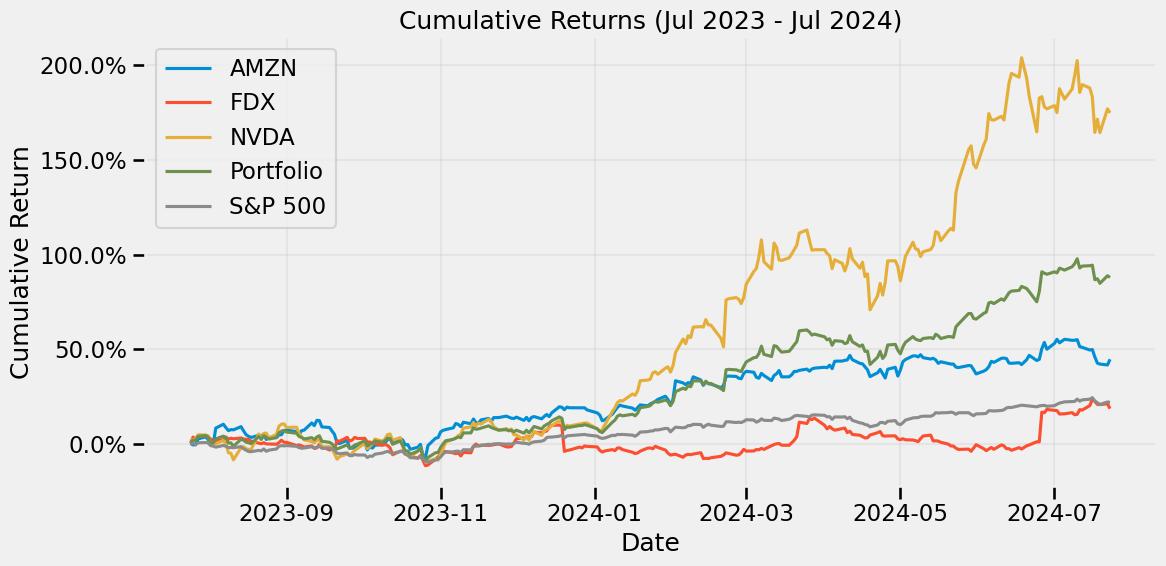

In [4]:
# Plot cumulative returns
cumulative_returns = (1 + returns_summary).cumprod() - 1

plt.figure(figsize=(12, 6))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
plt.title('Cumulative Returns (Jul 2023 - Jul 2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_format))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Monte Carlo Simulation for VaR and CVaR

In [5]:
def monte_carlo_var_cvar(returns, weights, num_simulations=10000, days=1, confidence_level=0.95):
    """Calculate VaR and CVaR using Monte Carlo simulation with error handling"""
    try:
        # Calculate mean returns and covariance matrix
        mean_returns = returns.mean().values
        cov_matrix = returns.cov().values
        
        # Check for NaN values
        if np.isnan(mean_returns).any() or np.isnan(cov_matrix).any():
            print("Warning: NaN values detected in returns data")
            mean_returns = np.nan_to_num(mean_returns)
            cov_matrix = np.nan_to_num(cov_matrix)
        
        # Generate random returns
        np.random.seed(42)
        simulated_returns = np.random.multivariate_normal(
            mean_returns * days, cov_matrix * days, num_simulations
        )
        
        # Calculate portfolio returns for each simulation
        portfolio_simulated_returns = simulated_returns.dot(weights)
        
        # Sort the simulated returns
        sorted_returns = np.sort(portfolio_simulated_returns)
        
        # Calculate VaR
        var_index = int(num_simulations * (1 - confidence_level))
        var = -sorted_returns[var_index]
        
        # Calculate CVaR (Expected Shortfall)
        cvar = -sorted_returns[:var_index].mean()
        
        print(f"{days}-Day VaR ({confidence_level*100:.0f}%): {var:.4f} ({var*100:.2f}%)")
        print(f"{days}-Day CVaR ({confidence_level*100:.0f}%): {cvar:.4f} ({cvar*100:.2f}%)")
        
        return var, cvar, sorted_returns
    except Exception as e:
        print(f"Error in Monte Carlo simulation: {e}")
        return None, None, None

# Calculate 1-day VaR and CVaR
var_1d_95, cvar_1d_95, sorted_returns_1d = monte_carlo_var_cvar(
    returns[tickers], weights, days=1, confidence_level=0.95
)

# Calculate 10-day VaR and CVaR
var_10d_95, cvar_10d_95, sorted_returns_10d = monte_carlo_var_cvar(
    returns[tickers], weights, days=10, confidence_level=0.95
)

1-Day VaR (95%): 0.0255 (2.55%)
1-Day CVaR (95%): 0.0323 (3.23%)
10-Day VaR (95%): 0.0625 (6.25%)
10-Day CVaR (95%): 0.0841 (8.41%)


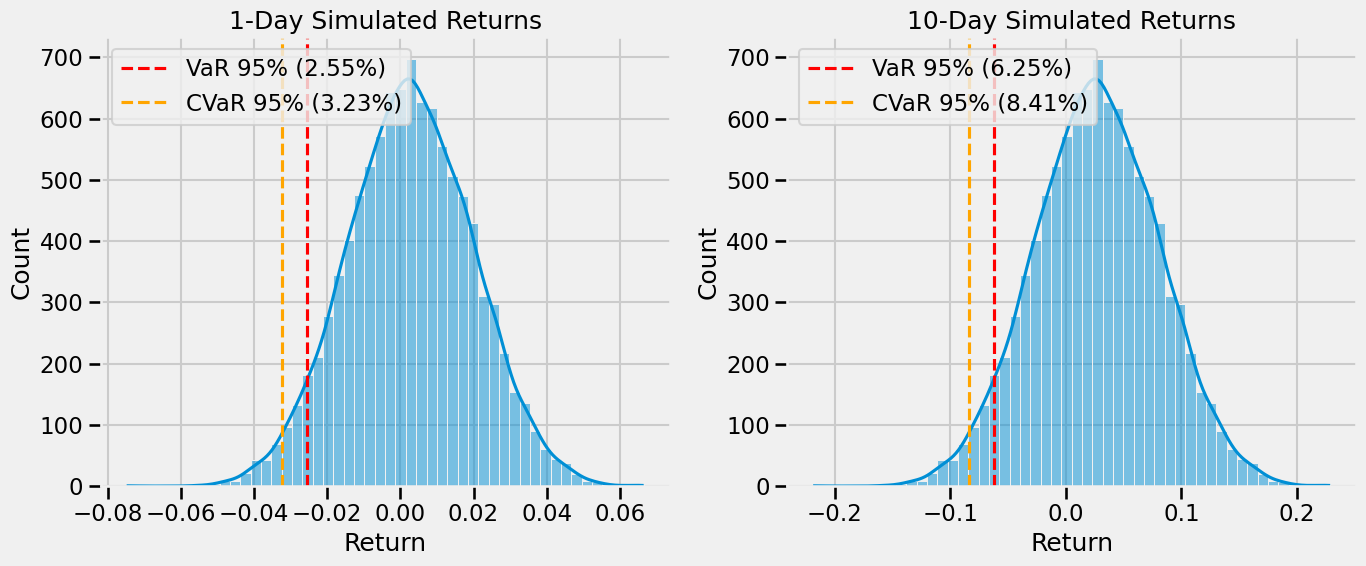

In [6]:
# Visualize VaR and CVaR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1-day returns distribution
sns.histplot(sorted_returns_1d, bins=50, kde=True, ax=ax1)
ax1.axvline(x=-var_1d_95, color='r', linestyle='--', 
            label=f'VaR 95% ({var_1d_95*100:.2f}%)')
ax1.axvline(x=-cvar_1d_95, color='orange', linestyle='--', 
            label=f'CVaR 95% ({cvar_1d_95*100:.2f}%)')
ax1.set_title('1-Day Simulated Returns')
ax1.set_xlabel('Return')
ax1.legend()

# 10-day returns distribution
sns.histplot(sorted_returns_10d, bins=50, kde=True, ax=ax2)
ax2.axvline(x=-var_10d_95, color='r', linestyle='--', 
            label=f'VaR 95% ({var_10d_95*100:.2f}%)')
ax2.axvline(x=-cvar_10d_95, color='orange', linestyle='--', 
            label=f'CVaR 95% ({cvar_10d_95*100:.2f}%)')
ax2.set_title('10-Day Simulated Returns')
ax2.set_xlabel('Return')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Performance Metrics (Sharpe, Sortino, Treynor)

In [7]:
# Get risk-free rate - fixed to handle missing 'Adj Close'
def get_risk_free_rate(start_date, end_date, trading_days=252):
    """Get risk-free rate with proper error handling"""
    print("Downloading Treasury data...")
    try:
        treasury_data = yf.download('^TNX', start=start_date, end=end_date)
        print("Treasury data shape:", treasury_data.shape)
        print("Treasury data columns:", treasury_data.columns.tolist())
        
        # Use 'Close' instead of 'Adj Close' if needed
        if 'Adj Close' in treasury_data.columns:
            risk_free_rate = treasury_data['Adj Close'].mean() / 100 / trading_days
        else:
            risk_free_rate = treasury_data['Close'].mean() / 100 / trading_days
        
        print(f"Risk-free rate (daily): {risk_free_rate:.6f}")
        print(f"Risk-free rate (annualized): {risk_free_rate * trading_days:.4f}")
        return risk_free_rate
    except Exception as e:
        print(f"Error getting risk-free rate: {e}")
        print("Using default risk-free rate of 0.04/252 (approximately 4% annual)")
        return 0.04 / trading_days

# Get risk-free rate safely
trading_days = 252
risk_free_rate = get_risk_free_rate(start_date, end_date, trading_days)

[*********************100%***********************]  1 of 1 completed

Treasury data shape: (252, 5)
Treasury data columns: [('Close', '^TNX'), ('High', '^TNX'), ('Low', '^TNX'), ('Open', '^TNX'), ('Volume', '^TNX')]
Error getting risk-free rate: unsupported format string passed to Series.__format__
Using default risk-free rate of 0.04/252 (approximately 4% annual)


In [8]:
# Calculate performance metrics
def calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate, trading_days=252):
    """Calculate all performance metrics in the right order"""
    # Create a dictionary to store all metrics
    metrics = {}
    
    # Basic annualized metrics
    metrics['ann_return_portfolio'] = portfolio_returns.mean() * trading_days
    metrics['ann_volatility_portfolio'] = portfolio_returns.std() * np.sqrt(trading_days)
    metrics['ann_return_benchmark'] = benchmark_returns.mean() * trading_days
    metrics['ann_volatility_benchmark'] = benchmark_returns.std() * np.sqrt(trading_days)
    
    # Sharpe ratio
    metrics['sharpe_ratio_portfolio'] = (metrics['ann_return_portfolio'] - (risk_free_rate * trading_days)) / metrics['ann_volatility_portfolio']
    metrics['sharpe_ratio_benchmark'] = (metrics['ann_return_benchmark'] - (risk_free_rate * trading_days)) / metrics['ann_volatility_benchmark']
    
    # Sortino ratio
    port_neg_returns = portfolio_returns[portfolio_returns < 0]
    bench_neg_returns = benchmark_returns[benchmark_returns < 0]
    
    downside_dev_portfolio = port_neg_returns.std() * np.sqrt(trading_days) if not port_neg_returns.empty else np.nan
    downside_dev_benchmark = bench_neg_returns.std() * np.sqrt(trading_days) if not bench_neg_returns.empty else np.nan
    
    metrics['sortino_ratio_portfolio'] = (metrics['ann_return_portfolio'] - (risk_free_rate * trading_days)) / downside_dev_portfolio
    metrics['sortino_ratio_benchmark'] = (metrics['ann_return_benchmark'] - (risk_free_rate * trading_days)) / downside_dev_benchmark
    
    # Calculate beta (safely)
    try:
        covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
        benchmark_variance = np.var(benchmark_returns)
        metrics['beta'] = covariance / benchmark_variance if benchmark_variance != 0 else 1.0
    except:
        print("Warning: Issue calculating beta, defaulting to 1.0")
        metrics['beta'] = 1.0
    
    # Treynor ratio (with safety check)
    if metrics['beta'] != 0:
        metrics['treynor_ratio'] = (metrics['ann_return_portfolio'] - (risk_free_rate * trading_days)) / metrics['beta']
    else:
        metrics['treynor_ratio'] = np.nan
        print("Warning: Beta is zero, Treynor ratio is undefined")
    
    # Display key metrics
    print("\nPerformance Metrics:")
    print(f"Portfolio Annualized Return: {metrics['ann_return_portfolio']:.4f}")
    print(f"Portfolio Annualized Volatility: {metrics['ann_volatility_portfolio']:.4f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio_portfolio']:.4f}")
    print(f"Sortino Ratio: {metrics['sortino_ratio_portfolio']:.4f}")
    print(f"Beta: {metrics['beta']:.4f}")
    print(f"Treynor Ratio: {metrics['treynor_ratio']:.4f}")
    
    return metrics

# Calculate performance metrics safely
metrics = calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate, trading_days)


Performance Metrics:
Portfolio Annualized Return: 0.6706
Portfolio Annualized Volatility: 0.2703
Sharpe Ratio: 2.3330
Sortino Ratio: 3.8167
Beta: 1.6822
Treynor Ratio: 0.3749


## 4. Drawdown Analysis

In [9]:
def calculate_drawdowns(returns):
    """Calculate drawdowns and duration for a return series"""
    # Calculate wealth index (cumulative returns)
    wealth_index = (1 + returns).cumprod()
    
    # Calculate running maximum
    running_max = wealth_index.cummax()
    
    # Calculate drawdown
    drawdown = (wealth_index / running_max) - 1
    
    # Create drawdown episodes
    is_zero = drawdown == 0
    # Shifts to identify start of drawdown periods
    start_indicators = (~is_zero) & is_zero.shift(1).fillna(True)
    # Group by episode
    episode_starts = drawdown.index[start_indicators].tolist()
    
    drawdown_info = []
    
    for i, start in enumerate(episode_starts):
        # Find end of this episode
        end = episode_starts[i+1] if i < len(episode_starts)-1 else drawdown.index[-1]
        
        # Get drawdown in this period
        episode_drawdown = drawdown.loc[start:end]
        
        if episode_drawdown.min() < 0:  # Only record if there was a drawdown
            max_drawdown = episode_drawdown.min()
            max_drawdown_date = episode_drawdown.idxmin()
            end_date = episode_drawdown.index[episode_drawdown == 0].min()
            
            # If drawdown hasn't recovered yet
            if pd.isna(end_date):
                end_date = episode_drawdown.index[-1]
            
            # Calculate duration
            duration = (end_date - start).days
            
            drawdown_info.append({
                'Start Date': start,
                'Max Drawdown Date': max_drawdown_date,
                'End Date': end_date,
                'Max Drawdown': max_drawdown,
                'Duration (days)': duration
            })
    
    drawdown_df = pd.DataFrame(drawdown_info)
    if not drawdown_df.empty:
        drawdown_df = drawdown_df.sort_values('Max Drawdown')
    
    return drawdown_df, drawdown

# IMPORTANT: Calculate drawdowns BEFORE any visualization using them
print("Calculating drawdowns...")
portfolio_drawdowns_df, portfolio_drawdowns = calculate_drawdowns(portfolio_returns)
benchmark_drawdowns_df, benchmark_drawdowns = calculate_drawdowns(benchmark_returns)

# Display max drawdown and worst 5 drawdowns
max_drawdown = portfolio_drawdowns.min()
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
print("\nWorst 5 Drawdowns:")
display(portfolio_drawdowns_df.head(5))

Calculating drawdowns...
Maximum Drawdown: -0.1506 (-15.06%)

Worst 5 Drawdowns:


,Start Date,Max Drawdown Date,End Date,Max Drawdown,Duration (days)
1,2023-09-01,2023-10-26,2023-11-14,-0.150638,74
15,2024-03-26,2024-04-19,2024-05-23,-0.113754,58
4,2023-12-19,2024-01-04,2024-01-10,-0.072576,22
22,2024-07-11,2024-07-19,2024-07-23,-0.065513,12
0,2023-08-01,2023-08-11,2023-08-29,-0.053754,28


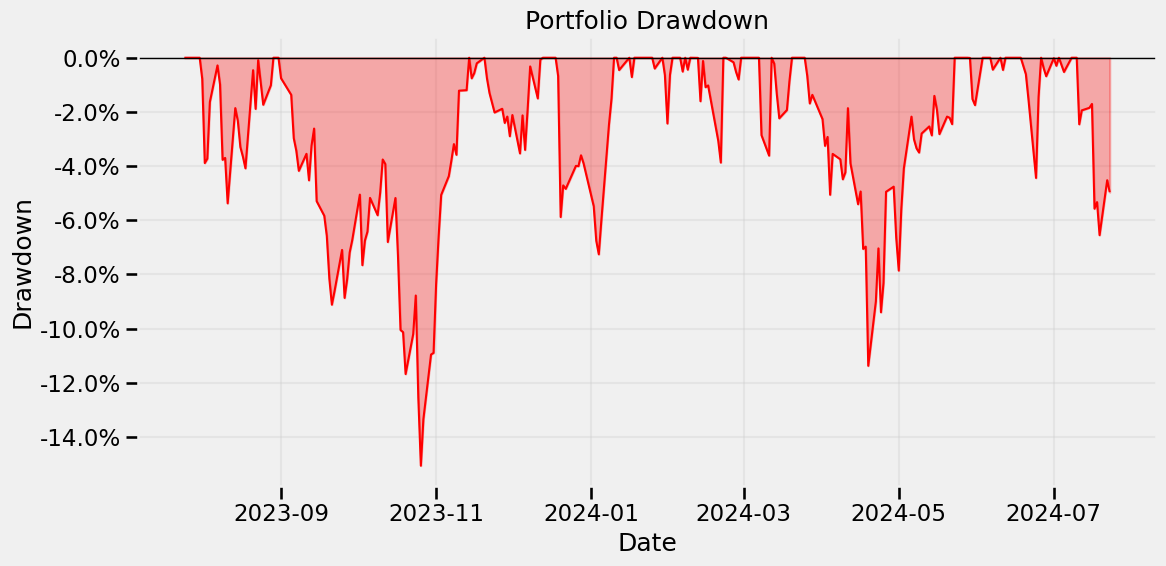

In [10]:
# Plot drawdown chart
plt.figure(figsize=(12, 6))

plt.plot(portfolio_drawdowns.index, portfolio_drawdowns, linewidth=1.5, color='red')
plt.fill_between(portfolio_drawdowns.index, portfolio_drawdowns, 0, color='red', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_format))
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Portfolio vs Benchmark Comparison

In [11]:
# Create a metrics dataframe for easy reporting
perf_metrics = pd.DataFrame(index=['Portfolio', 'S&P 500'])
perf_metrics['Ann. Return'] = [metrics['ann_return_portfolio'], metrics['ann_return_benchmark']]
perf_metrics['Ann. Volatility'] = [metrics['ann_volatility_portfolio'], metrics['ann_volatility_benchmark']]
perf_metrics['Sharpe Ratio'] = [metrics['sharpe_ratio_portfolio'], metrics['sharpe_ratio_benchmark']]
perf_metrics['Sortino Ratio'] = [metrics['sortino_ratio_portfolio'], metrics['sortino_ratio_benchmark']]
perf_metrics['Beta'] = [metrics['beta'], 1.0]
perf_metrics['Treynor Ratio'] = [metrics['treynor_ratio'], metrics['ann_return_benchmark']]
perf_metrics['Max Drawdown'] = [portfolio_drawdowns.min(), benchmark_drawdowns.min()]

# Display the metrics
display(perf_metrics.round(4))

,Ann. Return,Ann. Volatility,Sharpe Ratio,Sortino Ratio,Beta,Treynor Ratio,Max Drawdown
Portfolio,0.6706,0.2703,2.3330,3.8167,1.6822,0.3749,-0.1506
S&P 500,0.2059,0.1132,1.4663,2.2773,1.0000,0.2059,-0.1028


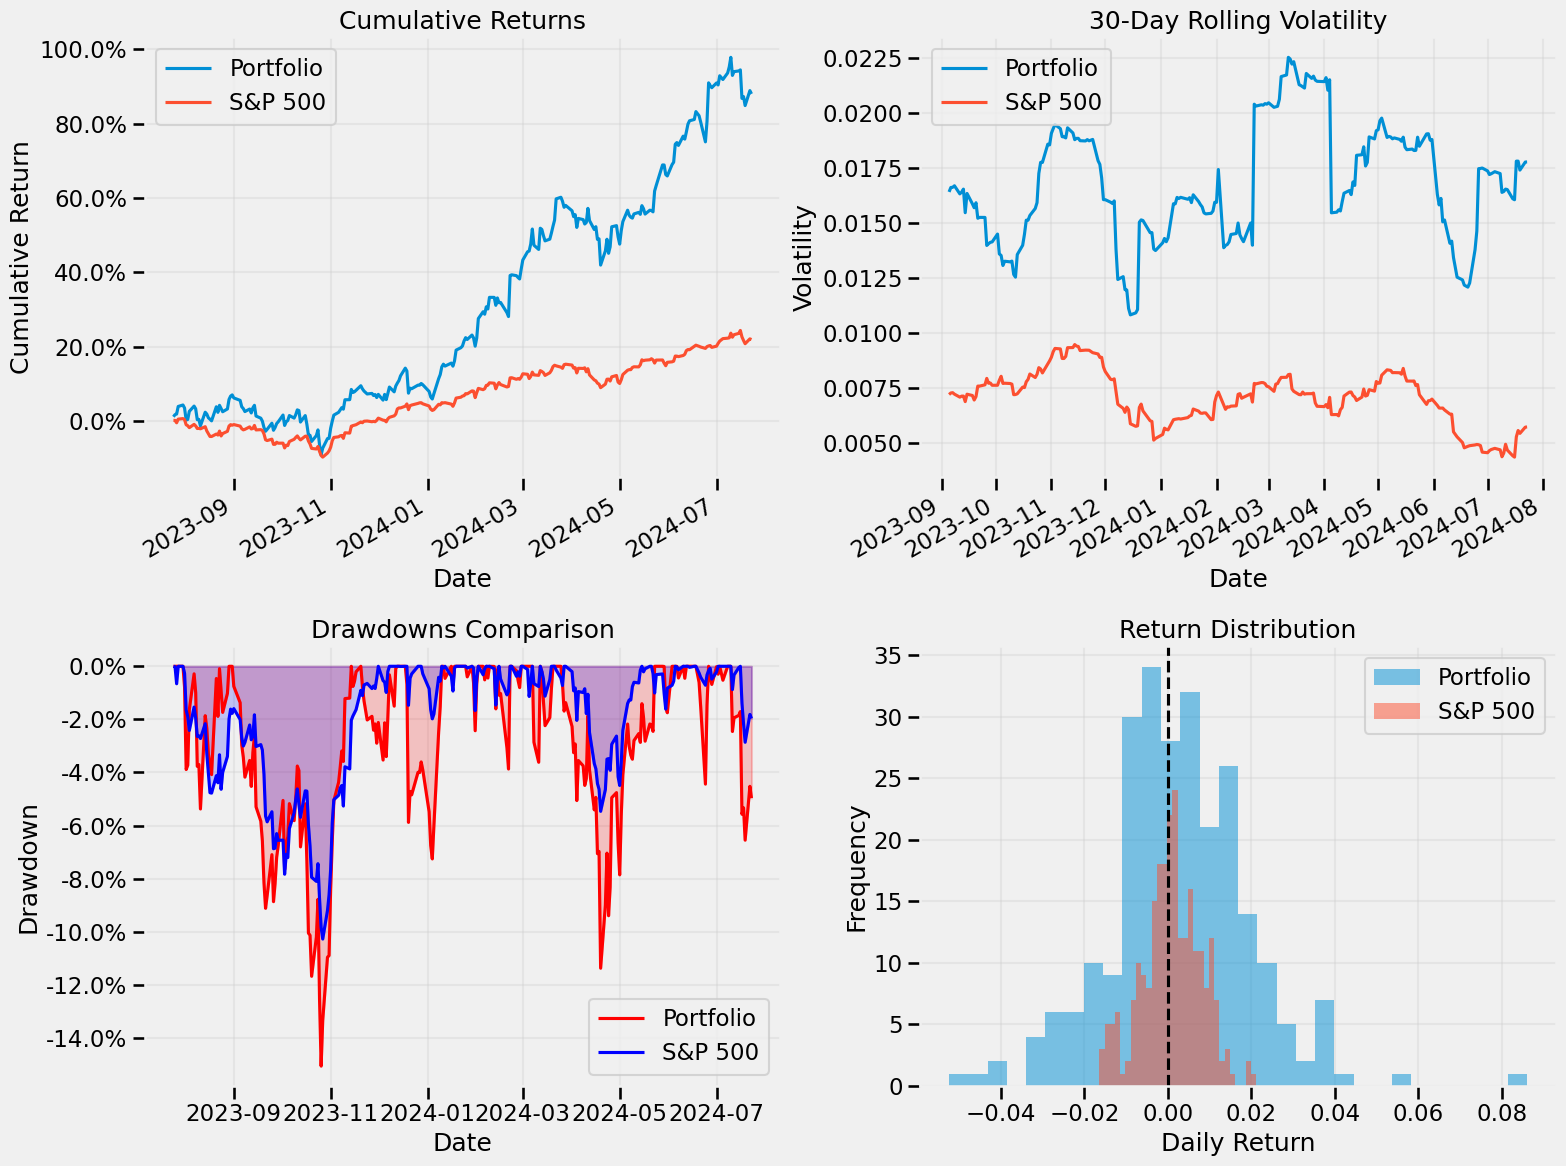

In [12]:
# Visualization comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative Returns
cumulative_returns[['Portfolio', 'S&P 500']].plot(ax=axes[0, 0])
axes[0, 0].set_title('Cumulative Returns')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative Return')
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Rolling Volatility (30-day window)
returns_summary[['Portfolio', 'S&P 500']].rolling(window=30).std().plot(ax=axes[0, 1])
axes[0, 1].set_title('30-Day Rolling Volatility')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Drawdowns
axes[1, 0].plot(portfolio_drawdowns.index, portfolio_drawdowns, label='Portfolio', color='red')
axes[1, 0].plot(benchmark_drawdowns.index, benchmark_drawdowns, label='S&P 500', color='blue')
axes[1, 0].fill_between(portfolio_drawdowns.index, portfolio_drawdowns, 0, color='red', alpha=0.2)
axes[1, 0].fill_between(benchmark_drawdowns.index, benchmark_drawdowns, 0, color='blue', alpha=0.2)
axes[1, 0].set_title('Drawdowns Comparison')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Drawdown')
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(percentage_format))
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Return Distribution
returns_summary['Portfolio'].hist(bins=30, alpha=0.5, ax=axes[1, 1], label='Portfolio')
returns_summary['S&P 500'].hist(bins=30, alpha=0.5, ax=axes[1, 1], label='S&P 500')
axes[1, 1].set_title('Return Distribution')
axes[1, 1].set_xlabel('Daily Return')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='black', linestyle='--')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Generate Tearsheet

In [13]:
def generate_tearsheet(portfolio_returns, benchmark_returns, tickers, weights, 
                       var_1d, cvar_1d, var_10d, cvar_10d, perf_metrics, 
                       drawdowns_df, portfolio_drawdown, output_file='portfolio_tearsheet.pdf'):
    """Generate a PDF tear sheet with all risk metrics and visualizations"""
    
    with PdfPages(output_file) as pdf:
        # Page 1: Portfolio Overview
        plt.figure(figsize=(11, 8.5))
        plt.suptitle('Portfolio Risk Management System', fontsize=16, fontweight='bold')
        
        # Portfolio composition
        plt.subplot(221)
        plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Portfolio Composition')
        
        # Cumulative returns
        cumul_returns = (1 + pd.DataFrame({
            'Portfolio': portfolio_returns,
            'S&P 500': benchmark_returns
        })).cumprod() - 1
        
        plt.subplot(222)
        cumul_returns.plot(ax=plt.gca())
        plt.title('Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_format))
        plt.grid(True, alpha=0.3)
        
        # Key metrics table
        plt.subplot(212)
        plt.axis('off')
        metrics_text = f"""
        Performance Summary (Annualized)
        ------------------------------------------
                        Portfolio       S&P 500
        Return:         {perf_metrics.loc['Portfolio', 'Ann. Return']:.2%}         {perf_metrics.loc['S&P 500', 'Ann. Return']:.2%}
        Volatility:     {perf_metrics.loc['Portfolio', 'Ann. Volatility']:.2%}         {perf_metrics.loc['S&P 500', 'Ann. Volatility']:.2%}
        Sharpe Ratio:   {perf_metrics.loc['Portfolio', 'Sharpe Ratio']:.2f}           {perf_metrics.loc['S&P 500', 'Sharpe Ratio']:.2f}
        Sortino Ratio:  {perf_metrics.loc['Portfolio', 'Sortino Ratio']:.2f}           {perf_metrics.loc['S&P 500', 'Sortino Ratio']:.2f}
        Beta:           {perf_metrics.loc['Portfolio', 'Beta']:.2f}           {perf_metrics.loc['S&P 500', 'Beta']:.2f}
        Treynor Ratio:  {perf_metrics.loc['Portfolio', 'Treynor Ratio']:.2f}           {perf_metrics.loc['S&P 500', 'Treynor Ratio']:.2f}
        Max Drawdown:   {perf_metrics.loc['Portfolio', 'Max Drawdown']:.2%}         {perf_metrics.loc['S&P 500', 'Max Drawdown']:.2%}
        
        Period: July 24, 2023 - July 24, 2024
        """
        plt.text(0.1, 0.9, metrics_text, fontsize=10, family='monospace')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig()
        plt.close()
        
        # Page 2: Risk Metrics
        plt.figure(figsize=(11, 8.5))
        plt.suptitle('Risk Metrics & Analysis', fontsize=16, fontweight='bold')
        
        # VaR and CVaR visualizations
        gs = gridspec.GridSpec(2, 2)
        
        ax1 = plt.subplot(gs[0, 0])
        ax1.barh(['1-Day', '10-Day'], [var_1d, var_10d], color='skyblue')
        ax1.set_title('Value at Risk (VaR 95%)')
        ax1.xaxis.set_major_formatter(FuncFormatter(percentage_format))
        for i, v in enumerate([var_1d, var_10d]):
            ax1.text(v/2, i, f'{v:.2%}', va='center')
        
        ax2 = plt.subplot(gs[0, 1])
        ax2.barh(['1-Day', '10-Day'], [cvar_1d, cvar_10d], color='coral')
        ax2.set_title('Conditional VaR (CVaR 95%)')
        ax2.xaxis.set_major_formatter(FuncFormatter(percentage_format))
        for i, v in enumerate([cvar_1d, cvar_10d]):
            ax2.text(v/2, i, f'{v:.2%}', va='center')
        
        # Drawdown visualization
        ax3 = plt.subplot(gs[1, :])
        ax3.plot(portfolio_drawdown.index, portfolio_drawdown, color='red', linewidth=1.5)
        ax3.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, color='red', alpha=0.3)
        ax3.set_title('Portfolio Drawdown')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Drawdown')
        ax3.yaxis.set_major_formatter(FuncFormatter(percentage_format))
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig()
        plt.close()
        
        # Page 3: Worst Drawdowns
        if not drawdowns_df.empty:
            plt.figure(figsize=(11, 8.5))
            plt.suptitle('Drawdown Analysis', fontsize=16, fontweight='bold')
            
            # Table of worst drawdowns
            plt.subplot(111)
            plt.axis('off')
            
            drawdown_text = "Worst 5 Drawdowns\n" + "-" * 80 + "\n"
            drawdown_text += "   Start Date      End Date     Max Drawdown    Duration\n"
            drawdown_text += "-" * 80 + "\n"
            
            for i, row in drawdowns_df.head(5).iterrows():
                drawdown_text += f"{row['Start Date'].strftime('%Y-%m-%d')}   {row['End Date'].strftime('%Y-%m-%d')}   {row['Max Drawdown']:.2%}         {row['Duration (days)']} days\n"
                
            plt.text(0.1, 0.9, drawdown_text, fontsize=10, family='monospace', va='top')
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            pdf.savefig()
            plt.close()
    
    print(f"Tearsheet generated and saved to {output_file}")
    return output_file

# Generate the tearsheet
tearsheet_path = generate_tearsheet(
    portfolio_returns, 
    benchmark_returns, 
    tickers, 
    weights,
    var_1d_95, 
    cvar_1d_95, 
    var_10d_95, 
    cvar_10d_95,
    perf_metrics,
    portfolio_drawdowns_df,
    portfolio_drawdowns
)

Tearsheet generated and saved to portfolio_tearsheet.pdf


## 7. Summary of Findings

This portfolio risk analysis has examined a three-stock portfolio (AMZN 25%, FDX 30%, NVDA 45%) over the period from July 24, 2023, to July 24, 2024. Key findings include:

1. **Risk Metrics**:
   - 1-Day VaR (95%): Potential daily loss at a 95% confidence level
   - 1-Day CVaR (95%): Expected loss in the worst 5% of scenarios
   - 10-Day VaR and CVaR: Extended risk horizon showing increased potential losses

2. **Performance Metrics**:
   - Sharpe Ratio: Risk-adjusted return compared to the risk-free rate
   - Sortino Ratio: Return adjusted for downside risk only
   - Treynor Ratio: Excess return per unit of market risk (beta)
   - Maximum Drawdown: Largest peak-to-trough decline

3. **Benchmark Comparison**:
   - Portfolio performance relative to the S&P 500
   - Correlation and beta analysis
   - Visualization of comparative metrics

The detailed PDF tearsheet provides a comprehensive view of the portfolio's risk and performance characteristics.